In [1]:
import os
import dlib
import wandb
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torchvision

from models.Embedding import Embedding
from models.Alignment import Alignment
from models.Blending import Blending

from utils.drive import open_url
from utils.shape_predictor import align_face

In [2]:
wandb.login()
wandb.init(project="barbershop", entity="geekyrakshit", job_type="predict")

config = wandb.config
config.wandb_project = 'barbershop'
config.wandb_entity = None
config.images_artifact = 'geekyrakshit/barbershop/II2S-Images:v0'
config.ffhq_models_artifact = 'geekyrakshit/barbershop/ffhq:v0'
config.segmentation_models_artifact = 'geekyrakshit/barbershop/segmentation:v0'
config.output_dir = 'output'
config.identity_image = '90.png'
config.structure_image = '15.png'
config.appearance_image = '117.png'
config.sign = 'realistic'
config.smooth = 5
config.size = 1024
config.channel_multiplier = 2
config.latent = 512
config.n_mlp = 8
config.device = "cuda"
config.seed = None
config.tile_latent = False
config.opt_name = 'adam'
config.learning_rate = 0.01
config.lr_schedule = 'fixed'
config.save_intermediate = False
config.save_interval = 300
config.verbose = False
config.percept_lambda = 1.0
config.l2_lambda = 1.0
config.p_norm_lambda = 0.001
config.l_F_lambda = 0.1
config.W_steps = 1100
config.FS_steps = 250
config.ce_lambda = 1.0
config.style_lambda = 40000.0
config.align_steps1 = 140
config.align_steps2 = 100
config.face_lambda = 1.0
config.hair_lambda = 1.0
config.blend_steps = 400
config.unprocessed_dir = 'unprocessed'
config.align_output_dir = 'input/face'
config.output_size = 1024
config.cache_dir = 'cache'
config.inter_method = 'bicubic'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geekyrakshit (use `wandb login --relogin` to force relogin)


In [3]:
def apply_align_faces(configs, identity_image):
    cache_dir = Path(configs.cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    output_dir = Path(configs.align_output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    print("Downloading Shape Predictor")
    f = open_url(
        "https://drive.google.com/uc?id=1huhv8PYpNNKbGCLOaYUjOgR1pY5pmbJx",
        cache_dir=cache_dir,
        return_path=True,
    )
    predictor = dlib.shape_predictor(f)

    identity_image = Path(identity_image)

    faces = align_face(str(identity_image), predictor)

    for i, face in enumerate(faces):
        if configs.output_size:
            factor = 1024 // configs.output_size
            assert configs.output_size * factor == 1024
            face_tensor = torchvision.transforms.ToTensor()(face).unsqueeze(0).cuda()
            face_tensor_lr = face_tensor[0].cpu().detach().clamp(0, 1)
            face = torchvision.transforms.ToPILImage()(face_tensor_lr)
            if factor != 1:
                face = face.resize(
                    (configs.output_size, configs.output_size), Image.LANCZOS
                )
        if len(faces) > 1:
            face.save(Path(configs.align_output_dir) / (identity_image.stem + f"_{i}.png"))
        else:
            face.save(Path(configs.align_output_dir) / (identity_image.stem + f".png"))

In [4]:
images_artifact = wandb.use_artifact(config.images_artifact, type="dataset")
images_artifact_dir = images_artifact.download()

ffhq_model_artifact = wandb.use_artifact(
    config.ffhq_models_artifact, type="model"
)
ffhq_model_artifact_dir = ffhq_model_artifact.download()
ffhq_model_file = os.path.join(ffhq_model_artifact_dir, "ffhq.pt")

segmentation_model_artifact = wandb.use_artifact(
    config.segmentation_models_artifact, type="model"
)
segmentation_model_artifact_dir = segmentation_model_artifact.download()
segmentation_model_file = os.path.join(
    segmentation_model_artifact_dir, "seg.pth"
)

wandb: Downloading large artifact II2S-Images:v0, 155.34MB. 120 files... Done. 0:0:0
wandb: Downloading large artifact ffhq:v0, 126.55MB. 1 files... Done. 0:0:0
wandb: Downloading large artifact segmentation:v0, 50.82MB. 1 files... Done. 0:0:0


In [5]:
identity_image = os.path.join(images_artifact_dir, config.identity_image)
structure_image = os.path.join(images_artifact_dir, config.structure_image)
appearance_image = os.path.join(images_artifact_dir, config.appearance_image)

apply_align_faces(config, identity_image)

90.png: Number of faces detected: 1


In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ii2s = Embedding(config, checkpoint_file=ffhq_model_file).to(device=device)

Loading StyleGAN2 from checkpoint: ./artifacts/ffhq:v0/ffhq.pt
Setting up Perceptual loss...
Loading model from: /home/paperspace/Workspace/Barbershop/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [7]:
align = Alignment(
    config,
    ffhq_checkpoint_file=ffhq_model_file,
    segmentation_checkpoint_file=segmentation_model_file,
).to(device=device)
aligned_image = align.align_images(
    identity_image,
    structure_image,
    sign=config.sign,
    align_more_region=False,
    smooth=config.smooth,
)
if structure_image != appearance_image:
    aligned_image = align.align_images(
        identity_image,
        appearance_image,
        sign=config.sign,
        align_more_region=False,
        smooth=config.smooth,
        save_intermediate=False,
    )

Loading StyleGAN2 from checkpoint: ./artifacts/ffhq:v0/ffhq.pt


In [8]:
blend = Blending(
    config,
    ffhq_checkpoint_file=ffhq_model_file,
    segmentation_checkpoint_file=segmentation_model_file,
).to(device=device)
blended_image = blend.blend_images(
    identity_image, structure_image, appearance_image, sign=config.sign
)

Loading StyleGAN2 from checkpoint: ./artifacts/ffhq:v0/ffhq.pt
Setting up Perceptual loss...
Loading model from: /home/paperspace/Workspace/Barbershop/losses/masked_lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /home/paperspace/Workspace/Barbershop/losses/masked_lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [9]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

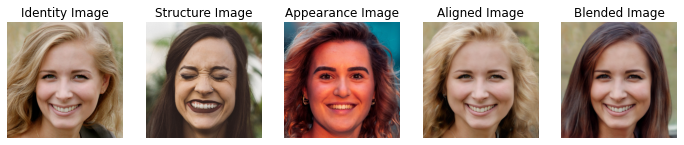

In [10]:
identity_image = np.array(Image.open(identity_image))
structure_image = np.array(Image.open(structure_image))
appearance_image = np.array(Image.open(appearance_image))

plot_results(
    images=[
        identity_image,
        structure_image,
        appearance_image,
        aligned_image,
        blended_image
    ], titles=[
        "Identity Image",
        "Structure Image",
        "Appearance Image",
        "Aligned Image",
        "Blended Image"
    ]
)

In [11]:
table_data = [[
    config.sign,
    wandb.Image(identity_image),
    wandb.Image(structure_image),
    wandb.Image(appearance_image),
    wandb.Image(aligned_image),
    wandb.Image(blended_image)
]]

table = wandb.Table(
    data=table_data,
    columns=[
        "Realistic/Fidelity",
        "Identity-Image",
        "Structure-Image",
        "Appearance-Image",
        "Aligned-Image",
        "Blended-Image",
    ],
)

wandb.log({"Predictions": table})

In [12]:
wandb.finish()